# 1. Tennis Surface Check

Use a linear regression and statsmodels to find which surface type predicts the most points for Federer in the `tennis.csv` dataset.

1. Give a one-paragraph interpretation of the coefficients, and the meaning of the p-value. 

2. Answer the following: should your regression include a constant term? Why or why not? How would it change the interpretation of your coefficient and p-value?

3. Do a t-test to find that the largest coefficient is statistically significantly different from the second largest (hint: you can run a t-test only with mean values and standard deviations)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

te = pd.read_csv('data/tennis.csv')
te = te.fillna(0.)

surfaces = list(set(list(te.surface)))
for surface in surfaces:
    te[surface] = te['surface'].map(lambda row: 1 if row == surface else 0)
    
te[surfaces + ['player1 total points won']]
# te.columns
y = te['player1 total points won']

x = sm.add_constant(te[surfaces])
model = sm.OLS(y,x).fit(cov_type='HC2')
model.summary()

/home/jlmgk/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     player1 total points won   R-squared:                       0.062
Model:                                  OLS   Adj. R-squared:                  0.058
Method:                       Least Squares   F-statistic:                     966.2
Date:                      Fri, 15 Jan 2021   Prob (F-statistic):               0.00
Time:                              19:38:21   Log-Likelihood:                -5955.6
No. Observations:                      1179   AIC:                         1.192e+04
Df Residuals:                          1173   BIC:                         1.195e+04
Df Model:                                 5                                         
Covariance Type:                        HC2                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             53.6325      1.003     53.477      0.000      51.667      55.598
Indoor: Hard      12.5357      2.027      6.184      0.000       8.563      16.509
Outdoor: Hard     24.2348      1.767     13.718      0.000      20.772      27.697
Indoor: Clay     -53.6325      1.003    -53.477      0.000     -55.598     -51.667
Indoor: Carpet     8.7886      4.246      2.070      0.038       0.467      17.111
Outdoor: Clay     22.7812      2.425      9.396      0.000      18.029      27.533
Outdoor: Grass    38.9247      3.016     12.906      0.000      33.014      44.836
==============================================================================
Omnibus:                       21.727   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.333
Skew:                          -0.261   Prob(JB):                     3.15e-06
Kurtosis:                       3.493   Cond. No.                     1.69e+16
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The smallest eigenvalue is 5.32e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### 1. Coeffs and p-values

It is worth noting our R squares i very low, variations are high around the predictors. However, this should not pose a problem since tennis games are trully never "predictable", per-se.

##### Coeffs
Two main things stand out: Indoor: Clay court is the only negative coefficient when predicting points, whereas Indoor: Carpet is the smallest coefficient. These coefficients indicate, in a positive coeffococase, that the more Federer plays on a positive coefficient surface (such as Grass), then more he is likely to score points or as many points as before on average . Contrarily, should he keep playing on negative coefficient surfaces, he will likely score less and less points  on average. This means Federer in consistently underperforming on Indoor Carpet courts, wheras he is performing consistently on all other types of courts. 

##### P-value
On the other hand, the Carpet court's p-value is the only non-zero p-value and s above our $\alpha = 0.01$, meaning we should not reject the null jupothesis for Carpet courts, and should disregard carpet courts as significant predictors.

In [2]:
te.surface.value_counts()

Outdoor: Hard     482
Outdoor: Clay     249
Indoor: Hard      226
Outdoor: Grass    140
Indoor: Carpet     76
Indoor: Clay        6
Name: surface, dtype: int64

In fact, we can assume this since the number of Indoor: Clay and Indoor: Carpet games are not numerous to be significant. We'll exclude those, let's isolate the most significant surfaces

In [3]:
def filter_down_surfaces(te, remove=[], add_constant=True):
    tec = te.copy()
    for rem in remove:        
        tec = tec[tec.surface != rem]
    y = tec['player1 total points won']
    surfaces = list(set(list(tec.surface)))
    print(tec.surface.value_counts())
    for surface in surfaces:
        tec[surface] = tec['surface'].map(lambda row: 1 if row == surface else 0)
    x = tec[surfaces]
    if add_constant:
        x = sm.add_constant(tec[surfaces])
    model = sm.OLS(y,x).fit(cov_type='HC2')
    summary = model.summary2()
    table = summary.tables[1]
    table = table[table['P>|z|'] > 0.01]
    if table.count()['P>|z|'] > 0:
        return filter_down_surfaces(te, list(table.index),add_constant=add_constant)
    return model

model2 = filter_down_surfaces(te, ['Indoor: Carpet'])
model2.summary()

Outdoor: Hard     482
Outdoor: Clay     249
Indoor: Hard      226
Outdoor: Grass    140
Indoor: Clay        6
Name: surface, dtype: int64


/home/jlmgk/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     player1 total points won   R-squared:                       0.058
Model:                                  OLS   Adj. R-squared:                  0.055
Method:                       Least Squares   F-statistic:                     1167.
Date:                      Fri, 15 Jan 2021   Prob (F-statistic):               0.00
Time:                              19:38:23   Log-Likelihood:                -5562.1
No. Observations:                      1103   AIC:                         1.113e+04
Df Residuals:                          1098   BIC:                         1.116e+04
Df Model:                                 4                                         
Covariance Type:                        HC2                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             52.1677      0.841     62.040      0.000      50.520      53.816
Indoor: Hard      14.0004      1.898      7.376      0.000      10.280      17.721
Outdoor: Hard     25.6995      1.637     15.695      0.000      22.490      28.909
Indoor: Clay     -52.1677      0.841    -62.040      0.000     -53.816     -50.520
Outdoor: Clay     24.2460      2.292     10.577      0.000      19.753      28.739
Outdoor: Grass    40.3894      2.874     14.055      0.000      34.757      46.022
==============================================================================
Omnibus:                       24.257   Durbin-Watson:                   1.586
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.667
Skew:                          -0.277   Prob(JB):                     3.61e-07
Kurtosis:                       3.582   Cond. No.                     6.47e+15
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The smallest eigenvalue is 3.47e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We now only have zero-value p-values for surfaces which we should consider. However, we can see now that by having removed some values for surfaces, our $R^2$ has gone down by 0.004, indicating our fit might not be as accurate (although ever so slightly).

Despite this, our p-values being non-zero and bellow our alpha of 0.01, we can reject the null hypothessis for Outdoor Clay, Grass, Hard and Indoor Hard and Clay surfaces.

We now see see that the highest coefficient, is for Outdoor Grass at 40.3894. This suggests, should Federer play on Outdoor Grass, it is very likely he will score more 2.8 times more points than on Indoor hard surfaces, 

#### 2. Constant Term
Let's proceed by removing Constant Terms.

In [4]:
model3 = filter_down_surfaces(te, [], add_constant=False)
model3.summary()

Outdoor: Hard     482
Outdoor: Clay     249
Indoor: Hard      226
Outdoor: Grass    140
Indoor: Carpet     76
Indoor: Clay        6
Name: surface, dtype: int64


/home/jlmgk/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/jlmgk/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/jlmgk/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/jlmgk/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     player1 total points won   R-squared:                       0.062
Model:                                  OLS   Adj. R-squared:                  0.058
Method:                       Least Squares   F-statistic:                       nan
Date:                      Fri, 15 Jan 2021   Prob (F-statistic):                nan
Time:                              19:38:26   Log-Likelihood:                -5955.6
No. Observations:                      1179   AIC:                         1.192e+04
Df Residuals:                          1173   BIC:                         1.195e+04
Df Model:                                 5                                         
Covariance Type:                        HC2                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Indoor: Hard      66.1681      2.084     31.746      0.000      62.083      70.253
Outdoor: Hard     77.8672      1.721     45.249      0.000      74.494      81.240
Indoor: Clay            0          0        nan        nan           0           0
Indoor: Carpet    62.4211      4.882     12.787      0.000      52.853      71.989
Outdoor: Clay     76.4137      2.612     29.256      0.000      71.294      81.533
Outdoor: Grass    92.5571      3.365     27.502      0.000      85.961      99.153
==============================================================================
Omnibus:                       21.727   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.333
Skew:                          -0.261   Prob(JB):                     3.15e-06
Kurtosis:                       3.493   Cond. No.                         8.96
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

We can tell right away that by ommitting the Constant Term, we've increased our $R^2$ by 0.004, which is not significant. This is expected since our predictor is the type of court surface, which is not a continuous variable, but a qualitative one.

Additionally, we can also tell that not having the constant terms does not change the difference in coefficients in any significant way. The mean of points per surface type is shown rather than the difference between the points mean per surface courts.

Therefore, adding or ommiting the Constant Term has no impact on prediction or fit.

#### 3. T-Test

In [5]:
from scipy.stats import ttest_ind_from_stats
top2 = model3.params.sort_values(ascending=False).nlargest(2)
top2
df = pd.DataFrame({
    'Court': list(top2.index)
})
te[te.surface == 'Outdoor: Grass']
df['NSize'] = df.Court.apply(lambda x: te[te.surface == x].surface.count())
df['CMean'] = df.Court.apply(lambda x: te[te.surface == x]['player1 total points won'].mean())
df['CVar'] = df.Court.apply(lambda x: te[te.surface == x]['player1 total points won'].var())

first = df.iloc[0]
second = one = df.iloc[1]
_, pvalue = ttest_ind_from_stats(mean1=first.CMean, std1=np.sqrt(first.CVar), nobs1=first.NSize,
                     mean2=second.CMean, std2=np.sqrt(second.CVar), nobs2=second.NSize)
if pvalue <= 0.01:
    print("We reject the null hypothesis, the top two coeffs are statistically significantly different")
else:
    print("We accept the null hypothesis, the top two coeffs are not statistically significantly different")
pvalue

We reject the null hypothesis, the top two coeffs are statistically significantly different


7.085417056631752e-05

# 2. Titanic prediction contest

Use whatever tricks you can to best model whether a passenger would survive the titanic disaster (using linear regression).

1. Use non-regularized regression to build the best model you can. Show 2 alternate model speficications and explain why you chose the one you did

2. Interpret the coefficients in your model. Which attributes best relate to survival probability? How does this relate to socio-economic characteristics and "real-world" interpretation?

3. Use regularized regression to build a purely predictive model. Can you improve your accuracy? Plot the regularized model against the interpretable model predictions in a regression plot to make your case.

In [6]:
import seaborn as sns

ti = sns.load_dataset('titanic')
values = {
    'who': {
        'man': 0,
        'woman': 1,
        'child': 2
    },
    'sex': {
        'male': 1,
        'female': 0
    },
    'alone':{False: 0, True: 1},
    'adult_male':{False: 0, True: 1},
}

"""
Only works if the list has no duplicates
"""
def remove_from_cols(df, remove=[]):
    return list(set(df.columns.tolist()) - set(remove))

def dummy_ize_data(df, vmap):
    dft = df.copy()
    for mapping in vmap.keys():
        dft[mapping] = dft[mapping].map(vmap[mapping])

    for categoricals in ['embark_town','class','embarked','deck']:
        uniques = dft[categoricals].value_counts().index.tolist()
#         print(uniques)
        vmap[categoricals] = {uniques[i]: i  for i in range(len(uniques))}
        dft[categoricals] = dft[categoricals].map(vmap[categoricals])
    return dft

def slim_data(df):
    if df[df['alive'] == df['survived']]['survived'].count() == df['survived'].count():
        dft = df.copy()
        return dft.drop(columns=['alive'])
    return df

In [7]:
ttc = dummy_ize_data(ti, values)
# ttc

In [8]:
"""
Test to see if "survive" and "alive" are the same, if so,
we can drop "alive" since we're looking at who survived.
.. you can only be alive if you survived
"""
titanic = slim_data(ttc)
titanic = titanic.drop(columns=['alive'])
titanic = titanic.dropna()
# titanic

# 1. Model

In [9]:
y = titanic.survived
cols = remove_from_cols(titanic, ['survived'])
model = sm.OLS(y,sm.add_constant(titanic[cols].astype(float))).fit(cov_type='HC2')
# sm.graphics.plot_fit(model, predictor)
model.summary()

/home/jlmgk/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     12.35
Date:                Fri, 15 Jan 2021   Prob (F-statistic):           7.91e-18
Time:                        19:38:33   Log-Likelihood:                -72.954
No. Observations:                 182   AIC:                             171.9
Df Residuals:                     169   BIC:                             213.6
Df Model:                          12                                         
Covariance Type:                  HC2                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.5166      0.285      5.319      0.000       0.958       2.075
pclass         -0.1573      0.090     -1.752      0.080      -0.333       0.019
alone          -0.0619      0.081     -0.763      0.445      -0.221       0.097
class           0.0207      0.086      0.240      0.810      -0.148       0.190
fare            0.0007      0.000      1.619      0.106      -0.000       0.001
embarked        0.0117      0.028      0.413      0.680      -0.044       0.067
who            -0.3061      0.223     -1.374      0.170      -0.743       0.131
adult_male     -1.1615      0.429     -2.707      0.007      -2.002      -0.321
sibsp          -0.0168      0.047     -0.358      0.721      -0.109       0.075
parch          -0.0976      0.045     -2.148      0.032      -0.187      -0.009
embark_town     0.0117      0.028      0.413      0.680      -0.044       0.067
sex             0.3140      0.215      1.464      0.143      -0.106       0.734
deck            0.0465      0.026      1.825      0.068      -0.003       0.097
age            -0.0046      0.002     -1.987      0.047      -0.009   -6.32e-05
==============================================================================
Omnibus:                        2.737   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                2.394
Skew:                           0.181   Prob(JB):                        0.302
Kurtosis:                       2.571   Cond. No.                     1.43e+18
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The smallest eigenvalue is 1.13e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## P-values
First, we notice that many of the p-values are above 0.5, which indicates they're most likely correlated to survability through randomness. We also noticed right away that only one predictor has a p-value of zero, adult_male. We also have several very low-p-values, we will filter out the dataframe to exract these.


In [10]:
from sklearn.preprocessing import PolynomialFeatures
y = titanic.survived

def get_columns_to_keep(dataframe,
                        y,
                        with_cols=[],
                        p_degree=1,
                        alpha=0.05,
                        add_constant=True):
    df = dataframe.copy()
    if len(with_cols) > 0:
        df = dataframe[with_cols].copy()
    cols = df.columns.tolist()
    if y.name in cols:
        cols.remove(y.name)
    x = df[cols]
    if add_constant:
        x = sm.add_constant(x)
    model = None
    if p_degree > 1: 
        poly_reg_s = PolynomialFeatures(p_degree)
        X_poly_s = poly_reg_s.fit_transform(x)
        model = sm.OLS(y,X_poly_s).fit(cov_type='HC2')
    else:
        model = sm.OLS(y,x).fit(cov_type='HC2')
    summary = model.summary2()
    print(summary)
    pvalues = summary.tables[1]['P>|z|'][1:]
    return [cols[i] for i in list(np.where(np.array(pvalues < alpha) == True))[0]]
    


Let's filter down to the top 3 p-value predictors by filtering out pvalues above 0.2

In [11]:
keep = get_columns_to_keep(titanic, titanic.survived, add_constant=True, alpha=0.2)
keep

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.362   
Dependent Variable: survived         AIC:                171.9082
Date:               2021-01-15 19:38 BIC:                213.5603
No. Observations:   182              Log-Likelihood:     -72.954 
Df Model:           12               F-statistic:        12.35   
Df Residuals:       169              Prob (F-statistic): 7.91e-18
R-squared:          0.404            Scale:              0.14057 
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
const          1.5166    0.2851   5.3190  0.0000   0.9578   2.0755
pclass        -0.1573    0.0898  -1.7521  0.0797  -0.3332   0.0187
sex            0.3140    0.2145   1.4636  0.1433  -0.1065   0.7345
age           -0.0046    0.0023  -1.9874  0.0469  -0.0091  -0.0001
sibsp         -0.016

/home/jlmgk/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)


['pclass', 'sex', 'age', 'parch', 'fare', 'who', 'adult_male', 'deck']

In [12]:
model = sm.OLS(y,titanic[keep]).fit(cov_type='HC2')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     690.3
Date:                Fri, 15 Jan 2021   Prob (F-statistic):          1.67e-127
Time:                        19:38:42   Log-Likelihood:                -92.920
No. Observations:                 182   AIC:                             201.8
Df Residuals:                     174   BIC:                             227.5
Df Model:                           8                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pclass        -0.0214      0.089     -0.241      0.809      -0.195       0.153
sex           -0.2366      0.233     -1.013      0.311      -0.694       0.221
age            0.0044      0.003      1.680      0.093      -0.001       0.010
parch         -0.1138      0.045     -2.518      0.012      -0.202      -0.025
fare           0.0015      0.000      4.437      0.000       0.001       0.002
who            0.6079      0.162      3.746      0.000       0.290       0.926
adult_male     0.3481      0.392      0.889      0.374      -0.420       1.116
deck           0.0326      0.026      1.265      0.206      -0.018       0.083
==============================================================================
Omnibus:                        0.941   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.625   Jarque-Bera (JB):                0.950
Skew:                          -0.171   Prob(JB):                        0.622
Kurtosis:                       2.907   Cond. No.                     1.33e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 1.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let's filter out additional high-value p-value predictors

In [13]:
keep = get_columns_to_keep(titanic, titanic.survived, with_cols=keep, add_constant=True, alpha=0.15)
keep

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.374   
Dependent Variable: survived         AIC:                164.7634
Date:               2021-01-15 19:38 BIC:                193.5994
No. Observations:   182              Log-Likelihood:     -73.382 
Df Model:           8                F-statistic:        18.87   
Df Residuals:       173              Prob (F-statistic): 3.28e-20
R-squared:          0.401            Scale:              0.13796 
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
const          1.5240    0.2574   5.9214  0.0000   1.0196   2.0284
pclass        -0.1675    0.0887  -1.8872  0.0591  -0.3414   0.0065
sex            0.3209    0.2123   1.5117  0.1306  -0.0952   0.7370
age           -0.0046    0.0023  -2.0337  0.0420  -0.0091  -0.0002
parch         -0.083

['pclass', 'sex', 'age', 'parch', 'fare', 'adult_male', 'deck']

In [14]:
model = sm.OLS(y,sm.add_constant(titanic[keep])).fit(cov_type='HC2')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     19.99
Date:                Fri, 15 Jan 2021   Prob (F-statistic):           1.55e-19
Time:                        19:38:44   Log-Likelihood:                -75.024
No. Observations:                 182   AIC:                             166.0
Df Residuals:                     174   BIC:                             191.7
Df Model:                           7                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1801      0.142      8.339      0.000       0.903       1.457
pclass        -0.1769      0.089     -1.979      0.048      -0.352      -0.002
sex            0.0906      0.102      0.892      0.372      -0.108       0.290
age           -0.0034      0.002     -1.489      0.136      -0.008       0.001
parch         -0.0963      0.038     -2.512      0.012      -0.171      -0.021
fare           0.0007      0.000      1.810      0.070   -5.83e-05       0.001
adult_male    -0.6304      0.122     -5.169      0.000      -0.869      -0.391
deck           0.0420      0.025      1.692      0.091      -0.007       0.091
==============================================================================
Omnibus:                        1.095   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.578   Jarque-Bera (JB):                1.138
Skew:                           0.101   Prob(JB):                        0.566
Kurtosis:                       2.670   Cond. No.                         953.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [15]:
# ti

We now have a much higher $R^2$, and a more acceptable set of p-values.

#### P-Value interpretations

We now have p-class, sex, age, fare and adult_male who have near-zero p-values, meaning their relationships to whether or not one would survive are statistically significant.


We have parch and deck which have much higher p-values, meaning that while their p-values are amongst the lowest, they have less significance as predictors to whether or not one would survive when compare to the latter 5 predictors. This makes sense compared to the latter, since there is less precise data on the deck predictor (as the dataframe shows), while parch (#parents/child) should be less significant than say, fare, as whether or not a passenger has a child with them is impossible to determine why qualitatiely/categorically, the data's label information on kaggle, also shows the following:

parch: The dataset defines family relations in this way
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for the

The parch in itself would probably skew information towards families of upper class, since low-income families generally didn't have nannies at the start of the 20th century. For this, we'll ommit deck and parch values:



In [16]:
keep = keep.copy()
# keep.remove('deck')
keep.remove('parch')
model = sm.OLS(y,sm.add_constant(titanic[keep])).fit(cov_type='HC2')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     18.40
Date:                Fri, 15 Jan 2021   Prob (F-statistic):           1.60e-16
Time:                        19:38:46   Log-Likelihood:                -77.674
No. Observations:                 182   AIC:                             169.3
Df Residuals:                     175   BIC:                             191.8
Df Model:                           6                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1630      0.152      7.643      0.000       0.865       1.461
pclass        -0.1896      0.091     -2.094      0.036      -0.367      -0.012
sex            0.0179      0.096      0.186      0.853      -0.171       0.207
age           -0.0029      0.002     -1.232      0.218      -0.008       0.002
fare           0.0003      0.000      0.667      0.505      -0.001       0.001
adult_male    -0.5501      0.118     -4.661      0.000      -0.781      -0.319
deck           0.0413      0.025      1.631      0.103      -0.008       0.091
==============================================================================
Omnibus:                        0.368   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.832   Jarque-Bera (JB):                0.520
Skew:                           0.042   Prob(JB):                        0.771
Kurtosis:                       2.752   Cond. No.                         934.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

We chose a model interpretation where we could narrow down predictors that had less co-dependency or causality between one another.
For example, we can see now that compared to pclass, fare and sex are much less statistically significant. Which makes sense since if we look at pclass + fare groupings, within first class only:

1. we have first class passengers that occupied every deck

In [25]:
group = pd.DataFrame({'count' : ti.groupby(['pclass','fare', 'deck']).size()}).reset_index()

first = group[group.pclass == 1]
print(len(first.deck.unique()), 'unique decks housing first class passengers')
first.head()

5 unique decks housing first class passengers


,pclass,fare,deck,count
0,1,0.0000,A,1
1,1,0.0000,B,2
2,1,5.0000,B,1
3,1,25.5875,E,1
4,1,25.9292,D,2


2. and we have 87 unique amount of fares paid out

In [26]:
print(len(first.fare.unique()), 'unique fares in first class')

87 unique fares in first class


Likewise, we also have sex and age with relatively high p-values, so if we forgo look into these, and only look at the relationship between the deck and passenger class relative to survival:

/home/jlmgk/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


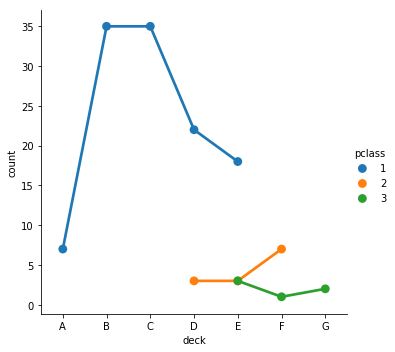

In [27]:
group2 = pd.DataFrame({'count' : ti.groupby(['pclass','deck', 'survived']).size()}).reset_index()

survived = group2[(group2.survived == 1)]
sns.factorplot("deck", "count", data=survived, hue="pclass")

Right away we can see that First class had a much better survival rate than 2nd and 3rd classes. Despite this, we see that the survival Rate within First Class is not very uniform, and appears quite random.

Finally, let's look at "adult_male" as a predictor.

/home/jlmgk/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


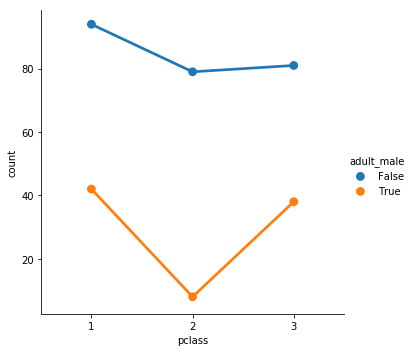

In [21]:
group3 = pd.DataFrame({'count' : ti.groupby(['pclass','adult_male', 'survived']).size()}).reset_index()

survived2 = group3[(group3.survived == 1)]
sns.factorplot("pclass", "count", data=survived2, hue="adult_male")

# House Price prediction

Using the techniques you learned, use everything you can to build the best **interpretable** (eg. non-regularized) regression model on the `house_price.csv` dataset. You also have `house_price_data_description.txt` to help -- full description of each column.

Here's a brief version of what you'll find in the data description file.

**SalePrice** - the property's sale price in dollars. **This is the target variable that you're trying to predict.**

Here are the features you can use (or engineer into new features!) for your `X` matrix:

    MSSubClass: The building class
    MSZoning: The general zoning classification
    LotFrontage: Linear feet of street connected to property
    LotArea: Lot size in square feet
    Street: Type of road access
    Alley: Type of alley access
    LotShape: General shape of property
    LandContour: Flatness of the property
    Utilities: Type of utilities available
    LotConfig: Lot configuration
    LandSlope: Slope of property
    Neighborhood: Physical locations within Ames city limits
    Condition1: Proximity to main road or railroad
    Condition2: Proximity to main road or railroad (if a second is present)
    BldgType: Type of dwelling
    HouseStyle: Style of dwelling
    OverallQual: Overall material and finish quality
    OverallCond: Overall condition rating
    YearBuilt: Original construction date
    YearRemodAdd: Remodel date
    RoofStyle: Type of roof
    RoofMatl: Roof material
    Exterior1st: Exterior covering on house
    Exterior2nd: Exterior covering on house (if more than one material)
    MasVnrType: Masonry veneer type
    MasVnrArea: Masonry veneer area in square feet
    ExterQual: Exterior material quality
    ExterCond: Present condition of the material on the exterior
    Foundation: Type of foundation
    BsmtQual: Height of the basement
    BsmtCond: General condition of the basement
    BsmtExposure: Walkout or garden level basement walls
    BsmtFinType1: Quality of basement finished area
    BsmtFinSF1: Type 1 finished square feet
    BsmtFinType2: Quality of second finished area (if present)
    BsmtFinSF2: Type 2 finished square feet
    BsmtUnfSF: Unfinished square feet of basement area
    TotalBsmtSF: Total square feet of basement area
    Heating: Type of heating
    HeatingQC: Heating quality and condition
    CentralAir: Central air conditioning
    Electrical: Electrical system
    1stFlrSF: First Floor square feet
    2ndFlrSF: Second floor square feet
    LowQualFinSF: Low quality finished square feet (all floors)
    GrLivArea: Above grade (ground) living area square feet
    BsmtFullBath: Basement full bathrooms
    BsmtHalfBath: Basement half bathrooms
    FullBath: Full bathrooms above grade
    HalfBath: Half baths above grade
    Bedroom: Number of bedrooms above basement level
    Kitchen: Number of kitchens
    KitchenQual: Kitchen quality
    TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
    Functional: Home functionality rating
    Fireplaces: Number of fireplaces
    FireplaceQu: Fireplace quality
    GarageType: Garage location
    GarageYrBlt: Year garage was built
    GarageFinish: Interior finish of the garage
    GarageCars: Size of garage in car capacity
    GarageArea: Size of garage in square feet
    GarageQual: Garage quality
    GarageCond: Garage condition
    PavedDrive: Paved driveway
    WoodDeckSF: Wood deck area in square feet
    OpenPorchSF: Open porch area in square feet
    EnclosedPorch: Enclosed porch area in square feet
    3SsnPorch: Three season porch area in square feet
    ScreenPorch: Screen porch area in square feet
    PoolArea: Pool area in square feet
    PoolQC: Pool quality
    Fence: Fence quality
    MiscFeature: Miscellaneous feature not covered in other categories
    MiscVal: $Value of miscellaneous feature
    MoSold: Month Sold
    YrSold: Year Sold
    SaleType: Type of sale
    SaleCondition: Condition of sale
